## Prepare dataset - 3 cls balanced, varying size

Create the train/test split, as well as the internal cross-validation, for the experiments in chapter 3 (varying dataset size and adversary power).

Dataset specifications:
- balanced 3-class (Melanocytic Nevi, Benign Keratosis-like and Melanoma)
- training sizes of 600, 1200, 2400 samples
- test size of 897
- no data leakage (all images of one patient are inside one dataset train/test, respectively in one specific fold)

For each dataset size, the output is saved in a file "3cls_balanced\_{dataset_size}\_{train/test}.csv". 

The train table has a column "fold" with values between 1-5, specifying the fold which holds the sample.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os, PIL
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from glob import glob
from PIL import Image
import json
import random as random

# to make the results are reproducible
np.random.seed(42)
random.seed(42)

## Load images and small data preprocessing

Dataset location

In [2]:
DATA_DIR = "/Users/andrei/Google Drive/_Facultate/MPhil Cambridge/Dissertation/data/HAM10000"
print(os.listdir(DATA_DIR))

['hmnist_28_28_L.csv', '.DS_Store', '3cls_balanced_test.csv', '3cls_balanced_2400_train_val.csv', '3cls_balanced_test_without_val.csv', 'saliency_maps', 'varying_training_ratio', 'hmnist_28_28_RGB.csv', 'ham10000_images_part_1', '3cls_balanced_2400_train.csv', 'hmnist_8_8_RGB.csv', '4cls_nv_mel_bkl_bcc.csv', 'mini_dataset.csv', '3cls_balanced_1200_train_val.csv', '3cls_small.csv', 'hmnist_8_8_L.csv', 'ham10000_images_part_2', 'HAM10000_metadata.csv', '3cls_balanced_600_train.csv', '4cls_nv_mel_bkl_bcc_imbalanced.csv', '3cls_balanced_600_train_val.csv', '3cls_balanced_1200_train.csv']


In [3]:
df_original = pd.read_csv(os.path.join(DATA_DIR, 'HAM10000_metadata.csv'))
df_original.head()

lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear

Drop columns not useful in our context (dx_type, age, sex, localization)

In [4]:
df_lite = df_original.drop(columns=['dx_type', 'age', 'sex', 'localization'])
df_lite.head()

lesion_id      image_id   dx
0  HAM_0000118  ISIC_0027419  bkl
1  HAM_0000118  ISIC_0025030  bkl
2  HAM_0002730  ISIC_0026769  bkl
3  HAM_0002730  ISIC_0025661  bkl
4  HAM_0001466  ISIC_0031633  bkl

Add column path column

In [5]:
# create dictionary {IMG_ID -> IMG_PATH}
image_paths = glob(os.path.join(DATA_DIR, '*', '*.jpg'))
image_id_to_path = {os.path.splitext(os.path.basename(x))[0]: x for x in image_paths}

# add column 'path'
df_lite['path_local'] = df_lite['image_id'].map(image_id_to_path.get)
df_lite['path_relative'] = df_lite['path_local'].map(lambda x: os.path.relpath(x, DATA_DIR))

In [6]:
# add full leasion name as column
lesion_type_to_name = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}
df_lite['lesion_name'] = df_lite['dx'].map(lesion_type_to_name.get)
df_lite.head()

lesion_id      image_id   dx  \
0  HAM_0000118  ISIC_0027419  bkl   
1  HAM_0000118  ISIC_0025030  bkl   
2  HAM_0002730  ISIC_0026769  bkl   
3  HAM_0002730  ISIC_0025661  bkl   
4  HAM_0001466  ISIC_0031633  bkl   

                                          path_local  \
0  /Users/andrei/Google Drive/_Facultate/MPhil Ca...   
1  /Users/andrei/Google Drive/_Facultate/MPhil Ca...   
2  /Users/andrei/Google Drive/_Facultate/MPhil Ca...   
3  /Users/andrei/Google Drive/_Facultate/MPhil Ca...   
4  /Users/andrei/Google Drive/_Facultate/MPhil Ca...   

                             path_relative                     lesion_name  
0  ham10000_images_part_1/ISIC_0027419.jpg  Benign keratosis-like lesions   
1  ham10000_images_part_1/ISIC_0025030.jpg  Benign keratosis-like lesions   
2  ham10000_images_part_1/ISIC_0026769.jpg  Benign keratosis-like lesions   
3  ham10000_images_part_1/ISIC_0025661.jpg  Benign keratosis-like lesions   
4  ham10000_images_part_2/ISIC_0031633.jpg  Benign keratosis-like lesions

In [7]:
df_lite['lesion_name'].value_counts()

Melanocytic nevi                  6705
Melanoma                          1113
Benign keratosis-like lesions     1099
Basal cell carcinoma               514
Actinic keratoses                  327
Vascular lesions                   142
Dermatofibroma                     115
Name: lesion_name, dtype: int64

Number of unique lesions per class

In [8]:
df_unique_lesions = df_lite.drop_duplicates(['lesion_id'])
df_unique_lesions['lesion_name'].value_counts()

Melanocytic nevi                  5403
Benign keratosis-like lesions      727
Melanoma                           614
Basal cell carcinoma               327
Actinic keratoses                  228
Vascular lesions                    98
Dermatofibroma                      73
Name: lesion_name, dtype: int64

## Split 1-lesions and n-lesions
Some lesions have multiple images from different angles. To avoid data leakage, lesions with multiple images must be part *only* of the training set.

Thus, the validation set includes only lesions which have one image.

Select lesions with only one image

In [9]:
images_per_lesion = df_lite.groupby('lesion_id').size()
lesion_1_ids = images_per_lesion[images_per_lesion == 1].index

In [10]:
print(f"There are {len(df_lite['image_id'].unique())} images")
print(f"There are {len(df_lite['lesion_id'].unique())} unique lesions")
print(f"There are {len(lesion_1_ids)} lesions with only one image")

There are 10015 images
There are 7470 unique lesions
There are 5514 lesions with only one image


In [11]:
def get_duplicates(x):
    if x in lesion_1_ids:
        return "unique"
    else:
        return "duplicated"

df_lite['duplicated'] = df_lite['lesion_id'].apply(get_duplicates)
df_lite.head()

lesion_id      image_id   dx  \
0  HAM_0000118  ISIC_0027419  bkl   
1  HAM_0000118  ISIC_0025030  bkl   
2  HAM_0002730  ISIC_0026769  bkl   
3  HAM_0002730  ISIC_0025661  bkl   
4  HAM_0001466  ISIC_0031633  bkl   

                                          path_local  \
0  /Users/andrei/Google Drive/_Facultate/MPhil Ca...   
1  /Users/andrei/Google Drive/_Facultate/MPhil Ca...   
2  /Users/andrei/Google Drive/_Facultate/MPhil Ca...   
3  /Users/andrei/Google Drive/_Facultate/MPhil Ca...   
4  /Users/andrei/Google Drive/_Facultate/MPhil Ca...   

                             path_relative                     lesion_name  \
0  ham10000_images_part_1/ISIC_0027419.jpg  Benign keratosis-like lesions    
1  ham10000_images_part_1/ISIC_0025030.jpg  Benign keratosis-like lesions    
2  ham10000_images_part_1/ISIC_0026769.jpg  Benign keratosis-like lesions    
3  ham10000_images_part_1/ISIC_0025661.jpg  Benign keratosis-like lesions    
4  ham10000_images_part_2/ISIC_0031633.jpg  Benign keratosis-like lesions    

   duplicated  
0  duplicated  
1  duplicated  
2  duplicated  
3  duplicated  
4  duplicated

In [12]:
df_lite['duplicated'].value_counts()

unique        5514
duplicated    4501
Name: duplicated, dtype: int64

We got:
- 5514 images coming from 1-lesions (lesions with only 1 image)
- 4501 images coming from n-lesions (lesions with multiple images)

In [13]:
df_1lesions = df_lite.loc[df_lite['duplicated'] == 'unique']
df_1lesions['lesion_name'].value_counts()

Melanocytic nevi                  4415
Benign keratosis-like lesions      440
Melanoma                           230
Basal cell carcinoma               175
Actinic keratoses                  151
Vascular lesions                    64
Dermatofibroma                      39
Name: lesion_name, dtype: int64

In [14]:
df_nlesions = df_lite[df_lite['duplicated'] == 'duplicated']
df_nlesions['lesion_name'].value_counts()

Melanocytic nevi                  2290
Melanoma                           883
Benign keratosis-like lesions      659
Basal cell carcinoma               339
Actinic keratoses                  176
Vascular lesions                    78
Dermatofibroma                      76
Name: lesion_name, dtype: int64

# Visualise lesions

In [15]:
def visualise_classes(df):
    n_samples = 6
    fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
    for n_axs, (type_name, type_rows) in zip(m_axs, df.sort_values(['lesion_name']).groupby('lesion_name')):
        n_axs[0].set_title(type_name)
        for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=2018).iterrows()):
            c_ax.imshow(PIL.Image.open(c_row.path_local))
            c_ax.axis('off')
    plt.plot()

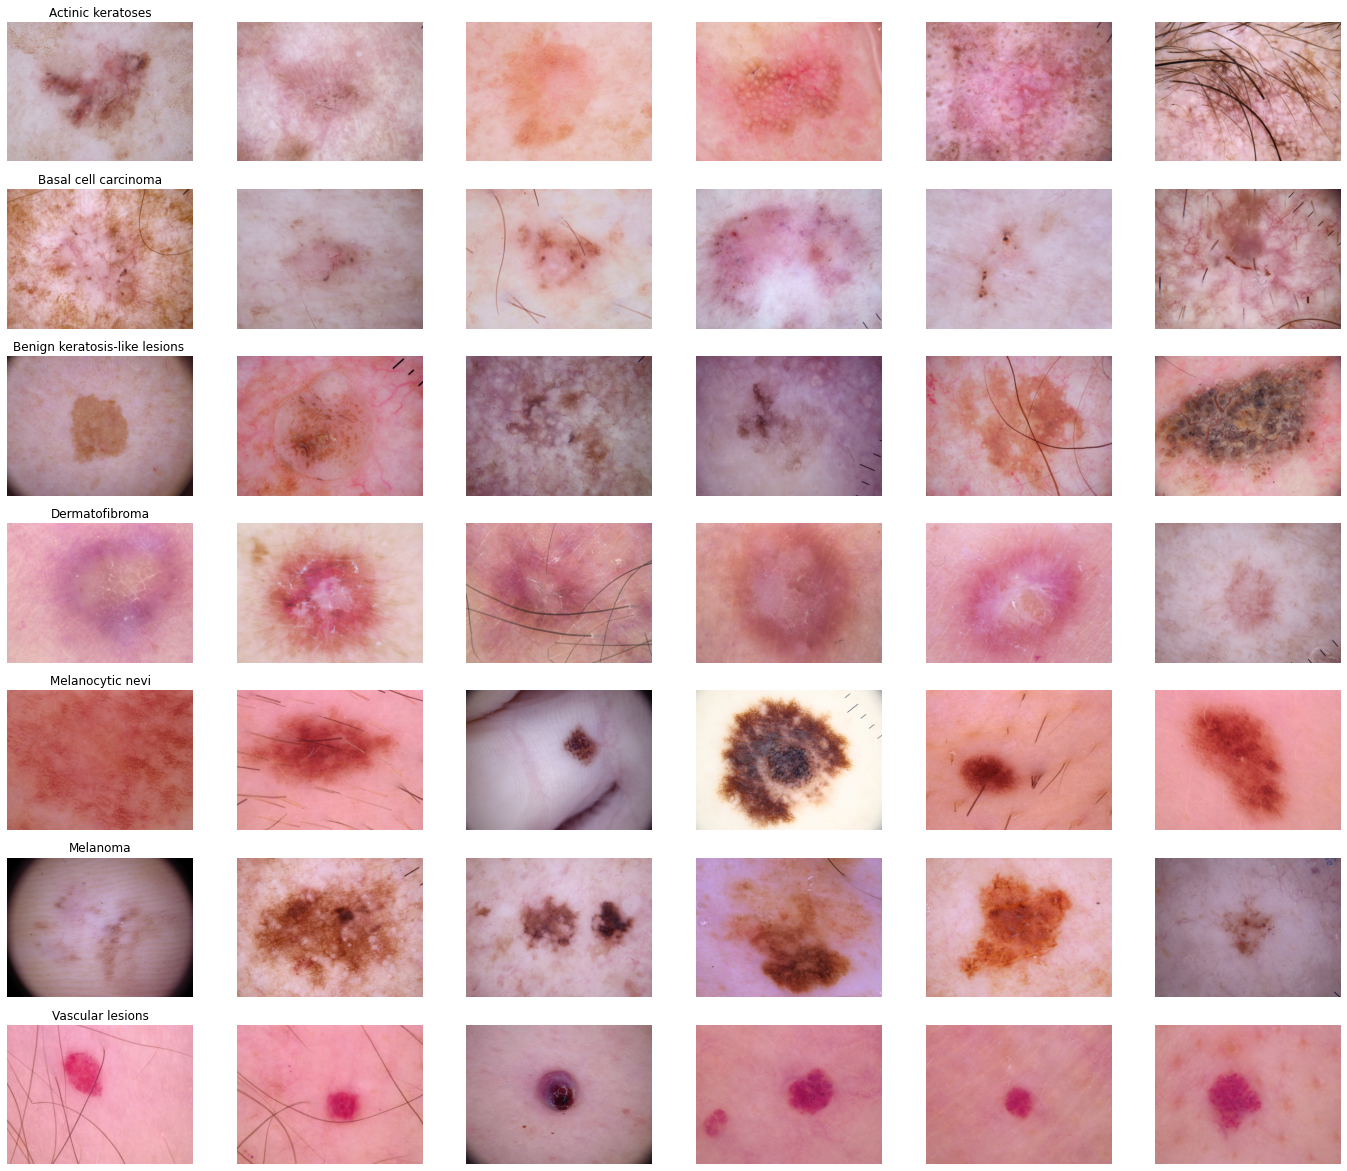

In [16]:
visualise_classes(df_1lesions)

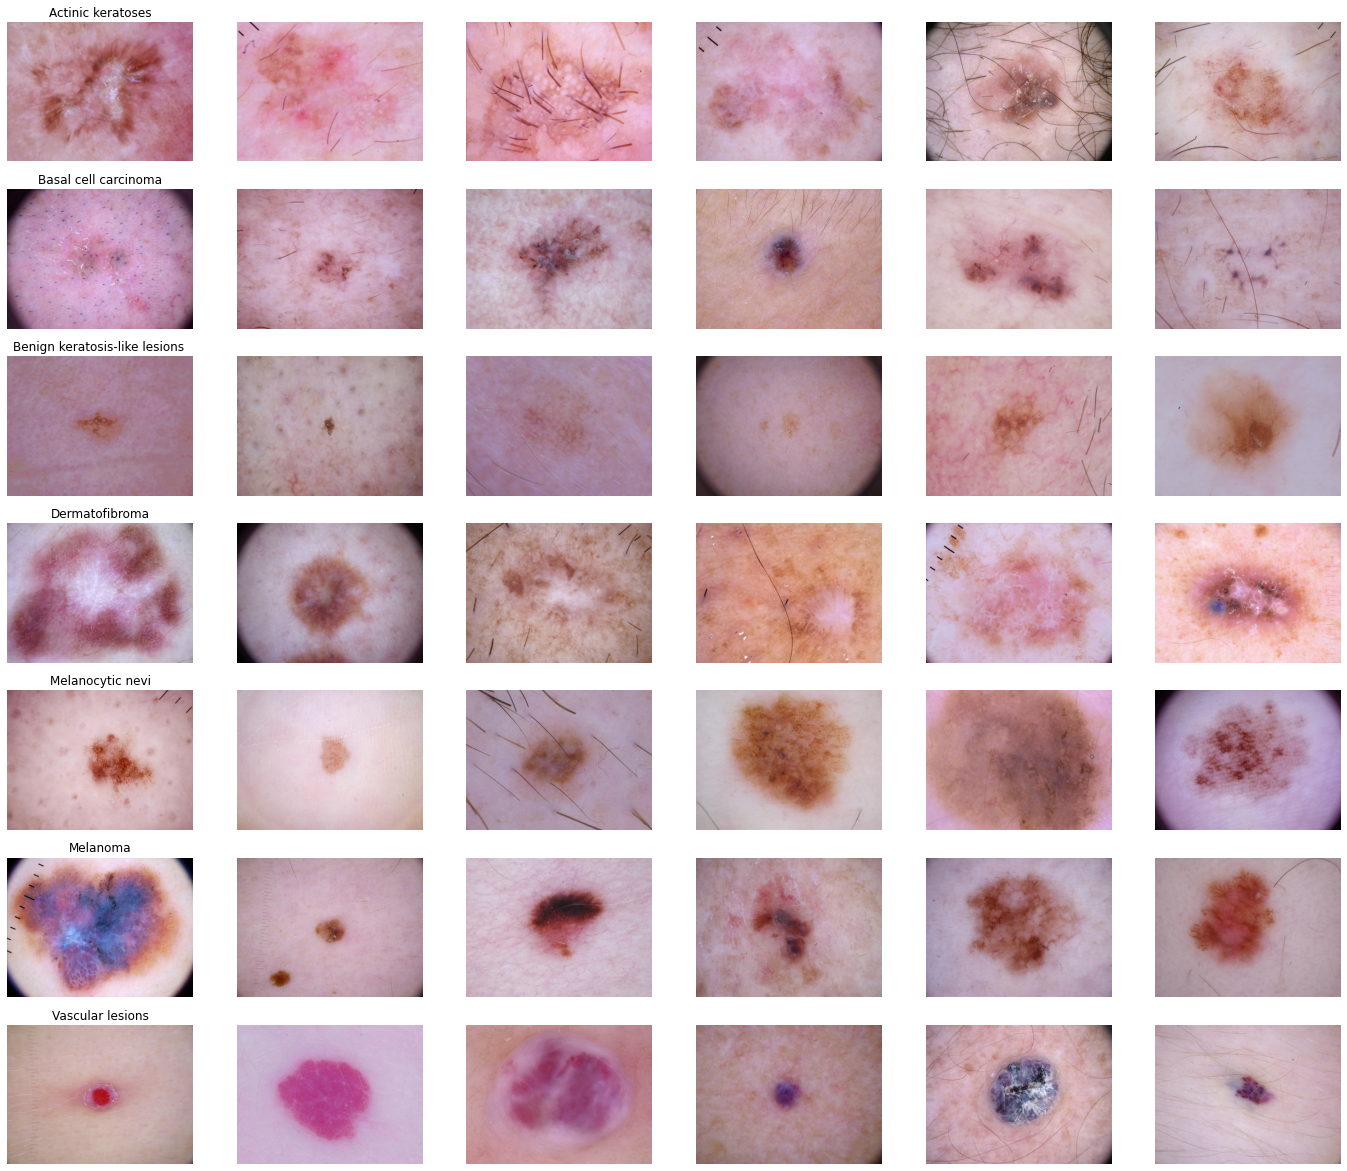

In [17]:
visualise_classes(df_nlesions)

# Make the splits

In [18]:
classes = ['nv', 'mel', 'bkl']
codes={'nv': 0, 'mel': 1, 'bkl': 2}

### Creating the test set

In [19]:
lesions_per_class = dict()
lesion_to_images = dict()

for cls in classes:
    lesions_per_class[cls] = list(df_lite[df_lite['dx'] == cls].lesion_id.unique())

    for lesion_id in lesions_per_class[cls]:
        lesion_to_images[lesion_id] = list(df_lite[df_lite['lesion_id'] == lesion_id].image_id)

In [20]:
def get_images(target, cls, available_lesions, lesion_to_images, remove_lesions):
    """
    Return a set of lesions that together have `count` images.

    - target (int): number of images to return
    - cls (str): the lesion class
    - available_lesions (set): set of lesions still available
    - lesion_to_images (dict): mapping from a lesion to a list of all its images
    - remove_lesions (boolean): if True, then also remove the taken lesions from the available ones

    Return:
    - list of lesions take
    """
    available_lesions_list = np.random.RandomState(seed=42).permutation(list(available_lesions[cls]))
    cnt = 0
    lesions_taken = list()

    for lesion in available_lesions_list:
        aux = len(lesion_to_images[lesion])

        if cnt + aux <= target:
            cnt += aux
            lesions_taken.append(lesion)

        if cnt == target:
            break
    
    if remove_lesions:
        for lesion in lesions_taken:
            available_lesions[cls].remove(lesion)
        print(f"Taken {len(lesions_taken)} lesions and remained with {len(available_lesions[cls])} of class {cls}")

    print(f"For class {cls} taken {cnt} images")

    return lesions_taken

### Select the test set

In [21]:
available_lesions_per_class = json.loads(json.dumps(lesions_per_class))

### !!! Take 299 in Test, or 249 test and 50 in val

In [22]:
test_lesions = set()
for cls in classes:
    lesions_taken = get_images(249, cls, available_lesions_per_class, lesion_to_images, remove_lesions=True)
    test_lesions = test_lesions.union(lesions_taken)
    print(len(test_lesions))

val_lesions = set()
for cls in classes:
    lesions_taken = get_images(50, cls, available_lesions_per_class, lesion_to_images, remove_lesions=True)
    val_lesions = val_lesions.union(lesions_taken)
    print(len(val_lesions))

Taken 191 lesions and remained with 5212 of class nv
For class nv taken 249 images
191
Taken 145 lesions and remained with 469 of class mel
For class mel taken 249 images
336
Taken 168 lesions and remained with 559 of class bkl
For class bkl taken 249 images
504
Taken 37 lesions and remained with 5175 of class nv
For class nv taken 50 images
37
Taken 29 lesions and remained with 440 of class mel
For class mel taken 50 images
66
Taken 30 lesions and remained with 529 of class bkl
For class bkl taken 50 images
96


#### Save the test set

In [23]:
len(test_lesions)

504

In [24]:
df_test = df_lite[df_lite['lesion_id'].isin(test_lesions)]
df_test['type'] = df_test.dx.map(codes).astype(int)
print(len(df_test))

df_val = df_lite[df_lite['lesion_id'].isin(val_lesions)]
df_val['type'] = df_val.dx.map(codes).astype(int)
print(len(df_val))

747
150


In [25]:
df_test.to_csv(os.path.join(DATA_DIR, '3cls_balanced_test_without_val.csv'), index=False)

### Do the 5 folds for each of the 600, 1200, 2400 training datasets

In [26]:
classes

['nv', 'mel', 'bkl']

In [27]:
def get_training_set(total_per_class, append_val, df_val, save_file_folder, save_file_name):
    """
    Args:
    - total_per_class (dict): mapping {cls: total_count}, telling how many sample in total should be per class
        in the entire training set
    - append_val (boolean): if `True` then append df_val to the training dataframe.
    - df_val (pandas.DataFrame): dataframe with items for validation
    - save_file_name (str): name of the file
    """
    available_lesions_per_class_for_folds = json.loads(json.dumps(available_lesions_per_class))
    dataset_size = np.sum(list(total_per_class.values()))
    print(f"-----Dataset of size {dataset_size}")
    no_folds = 5

    folds = dict()
    for i in range(1, no_folds+1):
        print(f"Fold {i}")
        folds[i] = set()

        for cls in classes:
            no_img_cls_per_fold = total_per_class[cls] / no_folds

            lesions_taken = get_images(no_img_cls_per_fold, cls, available_lesions_per_class_for_folds, lesion_to_images, remove_lesions=True)
            folds[i] = folds[i].union(lesions_taken)

    # Save training dataset
    df_train = df_lite.iloc[0:0]
    df_train['fold'] = pd.Series(list()).astype(int)
    

    for fold in range(1, no_folds+1):
        df_fold = df_lite[df_lite['lesion_id'].isin(folds[fold])]
        df_fold['fold'] = int(fold)
        df_train = df_train.append(df_fold)

    df_train['type'] = df_train.dx.map(codes)

    if append_val:
        df_val = df_val.copy()
        df_val['fold'] = 'validation'
        df_train = df_train.append(df_val)

    if save_file_folder != None:
        df_train.to_csv(os.path.join(DATA_DIR, save_file_folder, save_file_name), index=False)
    else:
        df_train.to_csv(os.path.join(DATA_DIR, save_file_name), index=False)

In [28]:
for nevi_size in [50, 100, 200, 400, 800, 1600, 3200]:
    print(f"\n\nComputing cor nevi_size = {nevi_size}\n\n")

    df_train = get_training_set({
        'nv': nevi_size,
        'mel': 800,
        'bkl': 800
    }, True, df_val, "varying_training_ratio", f"3cls_balanced_{nevi_size}nevi_train_val.csv")



Computing cor nevi_size = 50


-----Dataset of size 1650
Fold 1
Taken 9 lesions and remained with 5166 of class nv
For class nv taken 10 images
Taken 82 lesions and remained with 358 of class mel
For class mel taken 160 images
Taken 109 lesions and remained with 420 of class bkl
For class bkl taken 160 images
Fold 2
Taken 10 lesions and remained with 5156 of class nv
For class nv taken 10 images
Taken 84 lesions and remained with 274 of class mel
For class mel taken 160 images
Taken 100 lesions and remained with 320 of class bkl
For class bkl taken 160 images
Fold 3
Taken 9 lesions and remained with 5147 of class nv
For class nv taken 10 images
Taken 90 lesions and remained with 184 of class mel
For class mel taken 160 images
Taken 115 lesions and remained with 205 of class bkl
For class bkl taken 160 images
Fold 4
Taken 10 lesions and remained with 5137 of class nv
For class nv taken 10 images
Taken 89 lesions and remained with 95 of class mel
For class mel taken 160 images
Taken 10

In [29]:
get_training_set({
        'nv': 800,
        'mel': 800,
        'bkl': 800
    }, True, df_val, None, f"3cls_balanced_{2400}_train_val.csv")

get_training_set({
        'nv': 400,
        'mel': 400,
        'bkl': 400
    }, True, df_val, None, f"3cls_balanced_{1200}_train_val.csv")

get_training_set({
        'nv': 200,
        'mel': 200,
        'bkl': 200
    }, True, df_val, None, f"3cls_balanced_{600}_train_val.csv")

-----Dataset of size 2400
Fold 1
Taken 119 lesions and remained with 5056 of class nv
For class nv taken 160 images
Taken 82 lesions and remained with 358 of class mel
For class mel taken 160 images
Taken 109 lesions and remained with 420 of class bkl
For class bkl taken 160 images
Fold 2
Taken 137 lesions and remained with 4919 of class nv
For class nv taken 160 images
Taken 84 lesions and remained with 274 of class mel
For class mel taken 160 images
Taken 100 lesions and remained with 320 of class bkl
For class bkl taken 160 images
Fold 3
Taken 130 lesions and remained with 4789 of class nv
For class nv taken 160 images
Taken 90 lesions and remained with 184 of class mel
For class mel taken 160 images
Taken 115 lesions and remained with 205 of class bkl
For class bkl taken 160 images
Fold 4
Taken 125 lesions and remained with 4664 of class nv
For class nv taken 160 images
Taken 89 lesions and remained with 95 of class mel
For class mel taken 160 images
Taken 107 lesions and remained 

# Sanity checks for the data split

In [30]:
aux = pd.read_csv(os.path.join(DATA_DIR, '3cls_balanced_2400_train_val.csv'))
aux.shape

(2550, 9)

In [31]:
aux.image_id.value_counts()

ISIC_0031786    1
ISIC_0033443    1
ISIC_0026493    1
ISIC_0026750    1
ISIC_0033985    1
               ..
ISIC_0026868    1
ISIC_0032862    1
ISIC_0024395    1
ISIC_0025419    1
ISIC_0027326    1
Name: image_id, Length: 2550, dtype: int64

In [32]:
aux.lesion_id.value_counts()

HAM_0000835    6
HAM_0003789    6
HAM_0005263    6
HAM_0001863    6
HAM_0007343    5
              ..
HAM_0001271    1
HAM_0002816    1
HAM_0006322    1
HAM_0001700    1
HAM_0006840    1
Name: lesion_id, Length: 1686, dtype: int64